<a href="https://colab.research.google.com/github/kangnurrohman/sentiment-analysis-projects/blob/main/src/polarity-determination-with-bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.kaggle.com/code/kangnurrohman/polarity-determination-with-bert?scriptVersionId=112465598" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/review-of-the-application-pln-mobile/review of the application PLN mobile.xlsx


## Resource Check

In [ ]:
!nvidia-smi

Tue Nov 29 16:37:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 2 GPU(s) available.
we will use the GPU:  Tesla T4


## Install Library

In [ ]:
!pip install contractions

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.0 MB/s eta 0:00:00


## Load Library

In [ ]:
import re
import tqdm
import time
import random
import datetime
import unicodedata
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

## Load Data

In [ ]:
df = pd.read_excel('/kaggle/input/review-of-the-application-pln-mobile/review of the application PLN mobile.xlsx')
df.rename(columns = {'content':'review', 'score':'sentiment'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201042 entries, 0 to 201041
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              201042 non-null  object        
 1   userName              201042 non-null  object        
 2   userImage             201042 non-null  object        
 3   review                201042 non-null  object        
 4   sentiment             201042 non-null  int64         
 5   thumbsUpCount         201042 non-null  int64         
 6   reviewCreatedVersion  174363 non-null  object        
 7   at                    201042 non-null  datetime64[ns]
 8   replyContent          195639 non-null  object        
 9   repliedAt             195639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 15.3+ MB


## Exploratory Data Analysis

In [ ]:
df = df.sort_values(by='at', ascending=False)
df = df[['review', 'sentiment']]
df = df.replace({'sentiment' : {1:0, 2:0, 3:1, 4:2, 5:2 }})
df.head()

,review,sentiment
0,Sangat bermanfaat👍👍,2
1,PLN terbaik,2
2,😀,2
3,Mudah dan simpel untuk menikmati pelayanan PLN...,2
4,Baik,2


In [ ]:
x = df.sentiment.value_counts()
x

2    175750
0     19925
1      5367
Name: sentiment, dtype: int64

### Sentiment Distribution

Text(0, 0.5, 'sample')

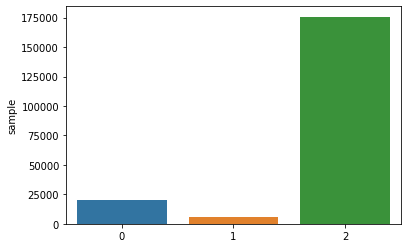

In [ ]:
sns.barplot(x.index, x)
plt.gca().set_ylabel('sample')

## Data Cleaning

In [ ]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

In [ ]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
%%time
df.review = pre_process_corpus(df.review)

100%|██████████| 201042/201042 [00:21<00:00, 9508.37it/s]

CPU times: user 21 s, sys: 87.3 ms, total: 21.1 s
Wall time: 21.2 s


In [ ]:
df.head()

,review,sentiment
0,sangat bermanfaat,2
1,pln terbaik,2
2,,2
3,mudah dan simpel untuk menikmati pelayanan pln...,2
4,baik,2


## Load BERT Tokenizer

In [ ]:
sentences = df.review.values
labels = df.sentiment.values

In [ ]:
print("load BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_cased = True)

load BERT Tokenizer


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
print('Original:', sentences[0])
print('Tokenized:', tokenizer.tokenize(sentences[0]))
print('Token IDS:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original: sangat bermanfaat
Tokenized: ['sangat', 'ber', '##man', '##fa', '##at']
Token IDS: [20514, 64560, 10629, 13240, 10552]


In [ ]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    input_ids.append(encoded_sent)
    
print('Original:', sentences[0])
print('Token IDS:', input_ids[0])

Original: sangat bermanfaat
Token IDS: [101, 20514, 64560, 10629, 13240, 10552, 102]


In [ ]:
print('Max Sentence length', max([len(sen) for sen in input_ids]))

Max Sentence length 188


In [ ]:
MAX_LEN = 256

print('padding/truncating all sentences to %d values' % MAX_LEN)
print('padding token:"{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print('Done')

padding/truncating all sentences to 256 values
padding token:"[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([  101, 20514, 64560, 10629, 13240, 10552,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
attention_mask = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_mask.append(att_mask)

## Data Preparation

In [ ]:
train_input, test_input, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state=42, test_size=0.1)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=42, test_size=0.1)

In [ ]:
print('---Train---')
print('input: ', train_input.shape)
print('label: ', train_labels.shape)
print('mask: ', np.array(train_mask).shape)

print('---Validation---')
print('input: ', validation_input.shape)
print('label: ', validation_labels.shape)
print('mask: ', np.array(validation_mask).shape)

print('---Test---')
print('input: ', test_input.shape)
print('label: ', test_labels.shape)
print('mask: ', np.array(test_mask).shape)

---Train---
input:  (162843, 256)
label:  (162843,)
mask:  (162843, 256)
---Validation---
input:  (18094, 256)
label:  (18094,)
mask:  (18094, 256)
---Test---
input:  (20105, 256)
label:  (20105,)
mask:  (20105, 256)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Model Pre-Trained BERT

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels = 3, output_attentions = False, output_hidden_states = False)
model.cuda()

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [ ]:
epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training BERT

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
  
  print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 4 =======
Training...
Batch    40 of 5,089.     Elapsed: 0:00:49
Batch    80 of 5,089.     Elapsed: 0:01:38
Batch   120 of 5,089.     Elapsed: 0:02:30
Batch   160 of 5,089.     Elapsed: 0:03:22
Batch   200 of 5,089.     Elapsed: 0:04:14
Batch   240 of 5,089.     Elapsed: 0:05:06
Batch   280 of 5,089.     Elapsed: 0:05:58
Batch   320 of 5,089.     Elapsed: 0:06:50
Batch   360 of 5,089.     Elapsed: 0:07:42
Batch   400 of 5,089.     Elapsed: 0:08:34
Batch   440 of 5,089.     Elapsed: 0:09:25
Batch   480 of 5,089.     Elapsed: 0:10:17
Batch   520 of 5,089.     Elapsed: 0:11:09
Batch   560 of 5,089.     Elapsed: 0:12:01
Batch   600 of 5,089.     Elapsed: 0:12:53
Batch   640 of 5,089.     Elapsed: 0:13:45
Batch   680 of 5,089.     Elapsed: 0:14:37
Batch   720 of 5,089.     Elapsed: 0:15:29
Batch   760 of 5,089.     Elapsed: 0:16:21
Batch   800 of 5,089.     Elapsed: 0:17:12
Batch   840 of 5,089.     Elapsed: 0:18:04
Batch   880 of 5,089.     Elapsed: 0:18:56
Batch   920 of

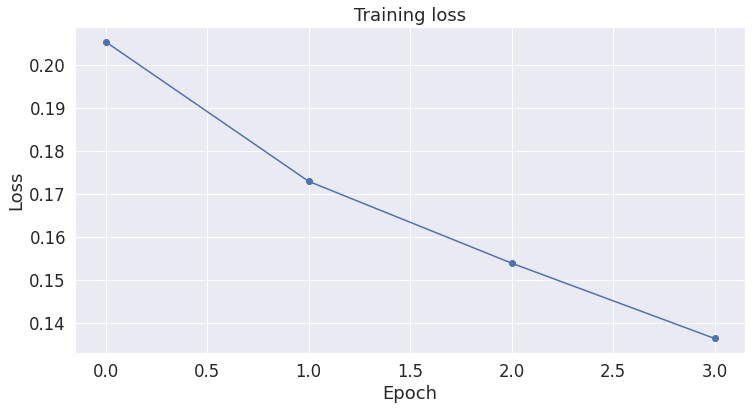

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Predict and Evaluate

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 20,105 test sentences
 DONE.


In [ ]:
# evaluation fo data imbalance
flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.724


In [ ]:
acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.940
